<a href="https://colab.research.google.com/github/MRnickRuss/AI/blob/main/Pr6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Практическая работа №6. Проектирование автоэнкодеров для решения прикладных задач**

[**Ссылка на код с пары**](https://colab.research.google.com/drive/1KfCEQly5k0PUdCR1w-my2-QmYfFexdvK?usp=sharing)

# Задание №1. Реализуйте автоэнкодер для колоризации чёрно-белых изображений

* **Чем больше объектов разных классов будет в исходном датасете, тем универсальнее будет работа обученной Вами модели**

> Например, если в Вашем датасете только кошки, то все объекты кроме кошек будут колоризоваться некорректно. Соответственно следует очень тщательно подойти к выбору датасета.

  * Для решения данной задачи может подойти датасет [CIFAR-100](https://www.kaggle.com/datasets/fedesoriano/cifar100), но его минус заключается в том, что разрешение изображений довольно низкое

* Хорошим вариантом будет использование датасета [ImageNet](https://paperswithcode.com/dataset/imagenet), но ввиду его объёмности, процесс обучения займет большое количество времени, поэтому Вы можете использовать одну из его [сокращенных версий](https://www.kaggle.com/datasets/ifigotin/imagenetmini-1000)

 **Конечный выбор датасета осуществляется по Вашему желанию, учитывая рекомендации приведенные выше.**


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from imutils import paths
import cv2
from google.colab.patches import cv2_imshow

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model

In [ ]:
def preprocess(array):
    """
    Нормализует предоставленный массив и преобразует его в соответствующий формат.
    """
    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 64, 64, 3))
    return array

In [ ]:
def display(array1, array2, n):
    """
    Отображает десять случайных изображений из каждого из предоставленных массивов.
    """

    indices = np.random.randint(len(array1), size=n)
    images1 = np.asarray(array1)[indices, :]
    images2 = np.asarray(array2)[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))

        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2

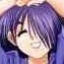

In [ ]:
images = []
wb_images = []
i = 0
imagePaths = sorted(list(paths.list_images("/content/gdrive/MyDrive/archive_2/Data")))
n = len(imagePaths)
for i in range(n):
	if i %10 == 0:
		print(i)
	image = cv2.imread(imagePaths[i]) # загружаем изображение
	try:
		image = cv2.resize(image, (64, 64))
		images.append(image) # добавляем в список
		gray1 = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
		gray3 = np.zeros_like(image)
		gray3[:,:,0] = gray1
		gray3[:,:,1] = gray1
		gray3[:,:,2] = gray1
		wb_images.append(gray3)
	except Exception as e:
		print(e)
		print('фото не обработалось',imagePaths[i])
print(i, 'фотографий')
cv2_imshow(images[0])

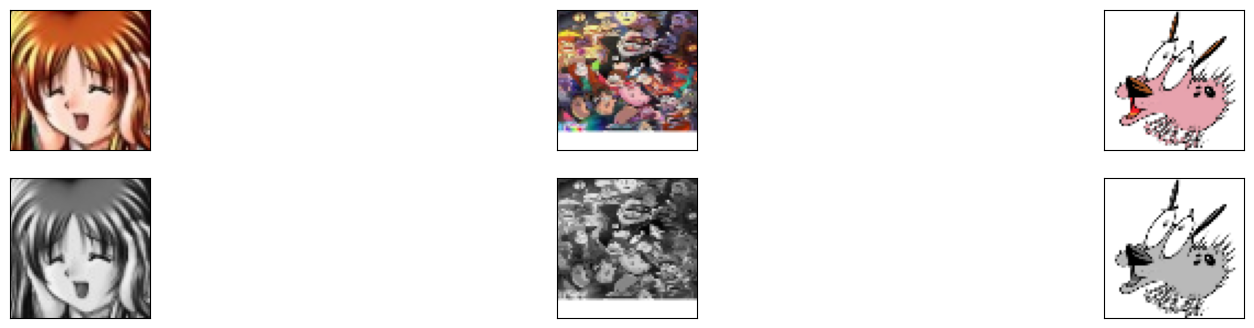

In [ ]:
display(images, wb_images,3)


In [ ]:
input = layers.Input(shape=(64, 64, 3))
# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
# x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
# x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
# x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)


from keras import optimizers

optimizer = optimizers.Adam(0.001)
# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer=optimizer, loss="mean_squared_error", metrics=['mse', 'accuracy'])
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 conv2d_transpose (Conv2DTr  (None, 64, 64, 32)        9248      
 anspose)                                                        
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 3)         867       
                                                                 
Total params: 11011 (43.01 KB)
Trainable params: 11011 (43.01

In [ ]:
from sklearn.model_selection import train_test_split
n_images = preprocess(np.asarray(images))
n_wb_images = preprocess(np.asarray(wb_images))

X_train, X_test, y_train, y_test = train_test_split(n_wb_images, n_images, test_size=0.2, random_state=0)

autoencoder.fit(
    x=X_train,
    y=y_train,
    epochs=100,
    batch_size=128,
    shuffle=True,
    validation_data=(X_test, y_test),
)

Epoch 1/100
19/19 [==============================] - 29s 1s/step - loss: 0.0839 - mse: 0.0839 - accuracy: 0.3618 - val_loss: 0.0744 - val_mse: 0.0744 - val_accuracy: 0.5932
Epoch 2/100
19/19 [==============================] - 28s 1s/step - loss: 0.0691 - mse: 0.0691 - accuracy: 0.6102 - val_loss: 0.0601 - val_mse: 0.0601 - val_accuracy: 0.5906
Epoch 3/100
19/19 [==============================] - 31s 2s/step - loss: 0.0491 - mse: 0.0491 - accuracy: 0.6025 - val_loss: 0.0346 - val_mse: 0.0346 - val_accuracy: 0.5874
Epoch 4/100
19/19 [==============================] - 29s 2s/step - loss: 0.0275 - mse: 0.0275 - accuracy: 0.6027 - val_loss: 0.0227 - val_mse: 0.0227 - val_accuracy: 0.5965
Epoch 5/100
19/19 [==============================] - 26s 1s/step - loss: 0.0213 - mse: 0.0213 - accuracy: 0.6112 - val_loss: 0.0202 - val_mse: 0.0202 - val_accuracy: 0.5977
Epoch 6/100
19/19 [==============================] - 28s 1s/step - loss: 0.0196 - mse: 0.0196 - accuracy: 0.6126 - val_loss: 0.0189 - v

19/19 [==============================] - 2s 80ms/step


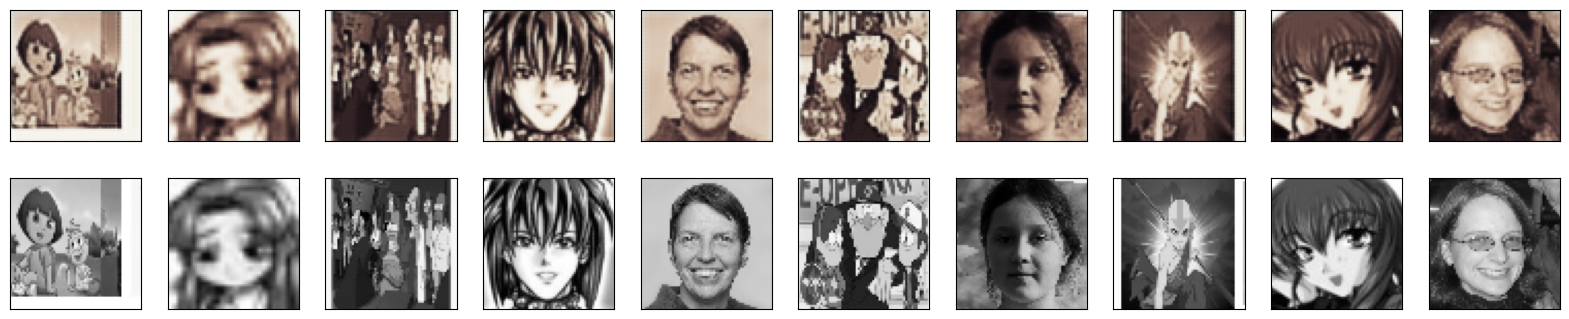

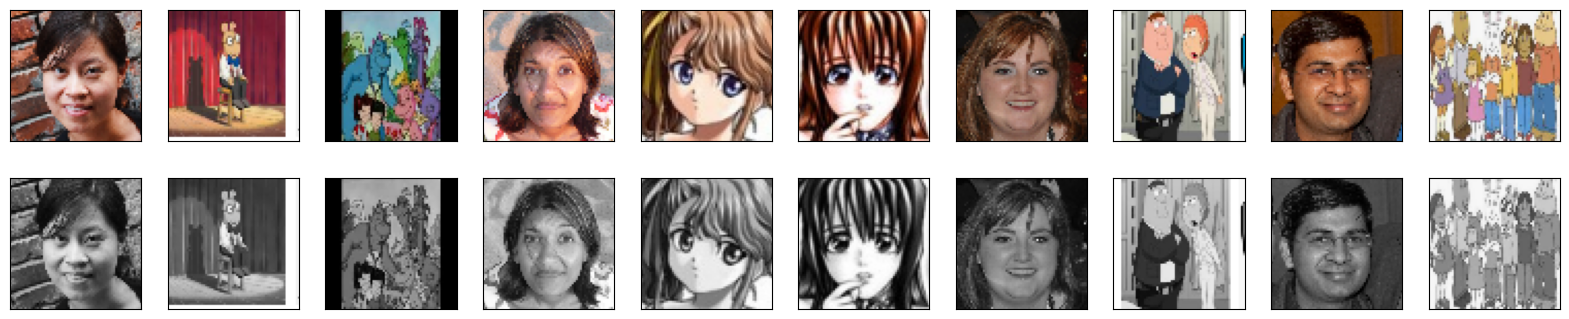

In [ ]:
predictions = autoencoder.predict(X_test)
display(predictions, X_test, 10)
display(images, wb_images,10)

In [ ]:
autoencoder.save("/content/gdrive/MyDrive/autoencoder/autoencoder_1.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Задание №2. Реализуйте автоэнкодер для удаления шума на однотипных изображениях

1.  Подберите датасет, состоящий из однотипных изображений, которые в реальной жизни часто подвержены зашумлению, например спутниковые снимки, ночные фотографии и т.д.

2.  Затем примените к ним операцию зашумления и обучите модель. Также учитывайте тип шума, который Вы применяете. Он должен быть приближен к естественному.

Хороший пример реализации подобной задачи: https://www.kaggle.com/code/michalbrezk/denoise-images-using-autoencoders-tf-keras

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.models import Model
from skimage.color import rgb2gray


def preprocess(array):
    """
    Нормализует предоставленный массив и преобразует его в соответствующий формат.

    """

    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 32, 32, 3))
    return array


def noise(array):
    """
    Добавляет случайный шум к каждому изображению в предоставленном массиве.

    """

    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)


def display(array1, array2):
    """
    Отображает десять случайных изображений из каждого из предоставленных массивов.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(rgb2gray(image1).reshape(32, 32, 1), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(rgb2gray(image2).reshape(32, 32, 1), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar100
import numpy as np

# загрузка данных
(train_images, train_labels), (test_images, test_labels) = cifar100.load_data()

# выбор изображений одного типа
class_idx = 0  # индекс выбранного класса
train_images_class = train_images[train_labels[:,0]==class_idx]
test_images_class = test_images[test_labels[:,0]==class_idx]

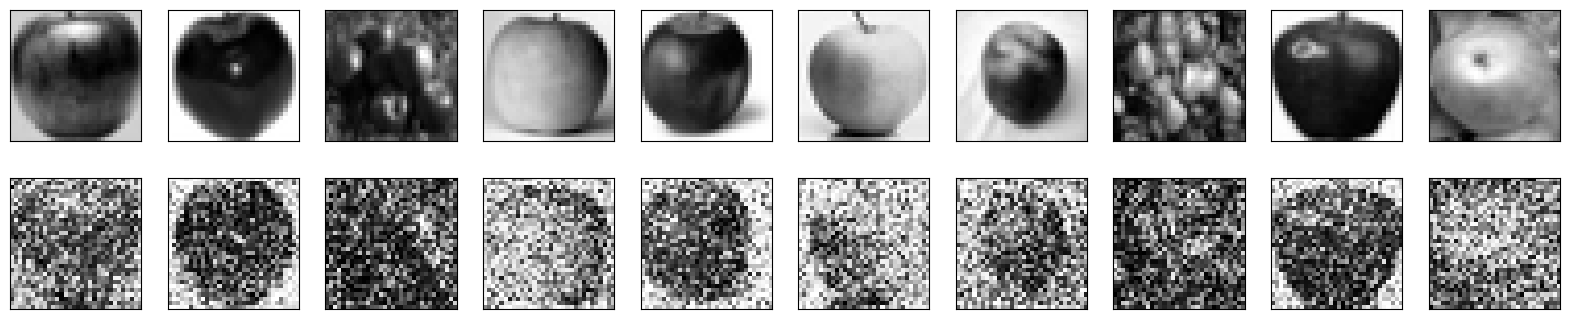

In [ ]:
# Нормализация и изменение формы данных
train_data = preprocess(train_images_class)
test_data = preprocess(test_images_class)

# Создание копии данных с добавленным шумом
noisy_train_data = noise(train_data)
noisy_test_data = noise(test_data)

# Отображение данных выборки и его версии с добавленным шумом
display(train_data, noisy_train_data)

In [41]:
input = layers.Input(shape=(32, 32, 3))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder_2 = Model(input, x)
autoencoder_2.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])
autoencoder_2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 8, 8, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_transpose_5 (Conv2D  (None, 16, 16, 32)        9248

In [ ]:
autoencoder_2.fit(
    x=noisy_train_data,
    y=train_data,
    epochs=100,
    batch_size=128,
    shuffle=True,
    validation_data=(test_data, noisy_test_data),
)

Epoch 1/100
4/4 [==============================] - 4s 482ms/step - loss: 0.6871 - accuracy: 0.6245 - val_loss: 0.6847 - val_accuracy: 0.5172
Epoch 2/100
4/4 [==============================] - 2s 395ms/step - loss: 0.6749 - accuracy: 0.7635 - val_loss: 0.6832 - val_accuracy: 0.5177
Epoch 3/100
4/4 [==============================] - 2s 397ms/step - loss: 0.6715 - accuracy: 0.7640 - val_loss: 0.6799 - val_accuracy: 0.5177
Epoch 4/100
4/4 [==============================] - 2s 399ms/step - loss: 0.6673 - accuracy: 0.7640 - val_loss: 0.6772 - val_accuracy: 0.5177
Epoch 5/100
4/4 [==============================] - 1s 370ms/step - loss: 0.6636 - accuracy: 0.7633 - val_loss: 0.6743 - val_accuracy: 0.5170
Epoch 6/100
4/4 [==============================] - 2s 400ms/step - loss: 0.6561 - accuracy: 0.7613 - val_loss: 0.6721 - val_accuracy: 0.5160
Epoch 7/100
4/4 [==============================] - 2s 634ms/step - loss: 0.6432 - accuracy: 0.7598 - val_loss: 0.6688 - val_accuracy: 0.5151
Epoch 8/100
4

4/4 [==============================] - 1s 69ms/step


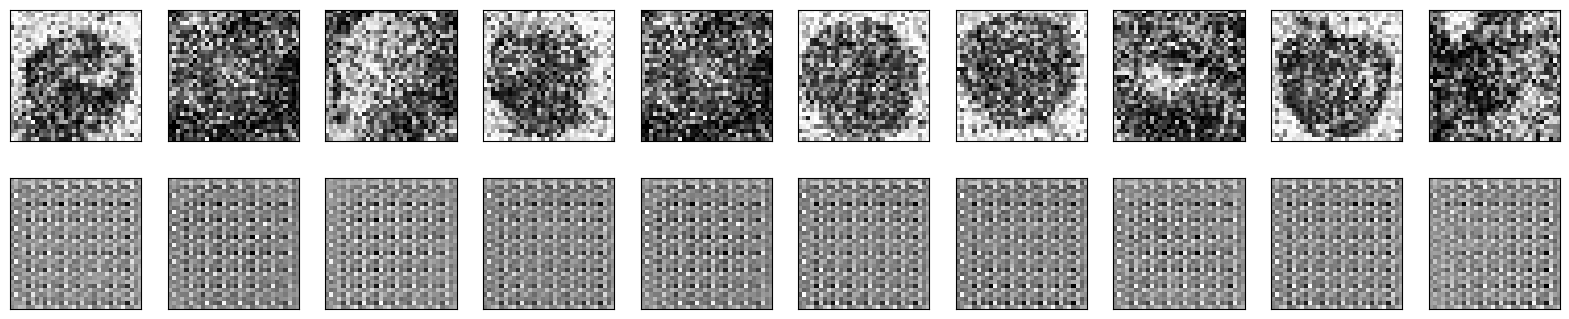

In [42]:
predictions = autoencoder_2.predict(noisy_test_data)
display(noisy_test_data, predictions)

In [43]:
autoencoder_2.save('/content/gdrive/MyDrive/autoencoder/autoencoder_2.h5')

# Задание №.3 Реализуйте автоэнкодер для улучшения качества изображения путём увеличения его разрешения (аскейлинг-[определение](https://dic.academic.ru/dic.nsf/ruwiki/346555))

1. На входной слой нейронной сети подаётся изображение с размерностью (256, 256,3) - X_test. В результате работы нейронной сети на выходном слое должно получиться изображение (512, 512, 3) - Y_test. В итоге мы получаем двукратный апскейл исходного изображения.

2. Датасет собираете из изображений, разрешение которых выше эталонного (512,512,3). Затем преобразуете их в указанные размерности и формируете из них обучающую и проверочную выборку.

3. Подумайте, каким образом можно будет адаптировать модель вашей нейронной сети для двухратного апскейла изображения с любой размерностью, большей, чем (256,256,3), с полным или частичным сохранением его исходных пропорций. Например: подаём на вход изображение с разрешением (1920, 1080, 3) - получаем изображение с разрешением (3840, 2160, 3), т.е. с полным сохранением исходных пропорций или (1792, 1024, 3) с частичным сохранением исходных пропорций.

> Подсказка: Для этого нужно реализовать алгоритм предварительной обработки исходного изображения, перед подачей его в нейронную сеть

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from imutils import paths
import cv2
from google.colab.patches import cv2_imshow

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model

In [2]:
def preprocess(array):
    """
    Нормализует предоставленный массив и преобразует его в соответствующий формат.
    """
    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 64, 64, 3))
    return array

2942
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2

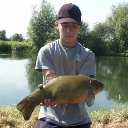

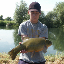

In [3]:
imagesX2 = []
imagesX = []
i = 0
imagePaths = sorted(list(paths.list_images("/content/gdrive/MyDrive/Data_6_WORK/train")))

n = len(imagePaths)
print(n)
for i in range(n):
	if i % 10 == 0:
		print(i)
	image = cv2.imread(imagePaths[i])
	try:
		imagesX2.append(cv2.resize(image, (128, 128)))
		imagesX.append(cv2.resize(image, (64, 64)))
	except Exception as e:
		print(e)
		print('фото не обработалось',imagePaths[i])
print(i, 'фотографий')
cv2_imshow(imagesX2[0])
cv2_imshow(imagesX[0])

In [8]:
input = layers.Input(shape=(64, 64, 3))

# Encoder
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

from keras import optimizers

optimizer = optimizers.Adam(0.0001)
# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer=optimizer, loss="mean_squared_error", metrics=['mse', 'accuracy'])
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 64, 64, 64)        36928     
 Transpose)                                                      
                                                                 
 conv2d_transpose_3 (Conv2D  (None, 128, 128, 64)      36928     
 Transpose)                                                      
                                                           

In [5]:
def preprocess(array, n):
    """
    Нормализует предоставленный массив и преобразует его в соответствующий формат.
    """
    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), n, n, 3))
    return array

In [6]:
from sklearn.model_selection import train_test_split

print(np.asarray(imagesX).shape, np.asarray(imagesX2).shape)
images256 = preprocess(np.asarray(imagesX), 64)
images512 = preprocess(np.asarray(imagesX2), 128)

X_train, X_test, y_train, y_test = train_test_split(images256, images512, test_size=0.2, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2942, 64, 64, 3) (2942, 128, 128, 3)
(2353, 64, 64, 3) (589, 64, 64, 3) (2353, 128, 128, 3) (589, 128, 128, 3)


In [10]:
autoencoder.fit(
    x=X_train,
    y=y_train,
    epochs=10,
    batch_size=32,
    shuffle=True,
    validation_data=(X_test, y_test),
)

Epoch 1/10
74/74 [==============================] - 244s 3s/step - loss: 0.0675 - mse: 0.0675 - accuracy: 0.4450 - val_loss: 0.0591 - val_mse: 0.0591 - val_accuracy: 0.4468
Epoch 2/10
74/74 [==============================] - 237s 3s/step - loss: 0.0439 - mse: 0.0439 - accuracy: 0.4493 - val_loss: 0.0283 - val_mse: 0.0283 - val_accuracy: 0.4633
Epoch 3/10
74/74 [==============================] - 234s 3s/step - loss: 0.0225 - mse: 0.0225 - accuracy: 0.4819 - val_loss: 0.0190 - val_mse: 0.0190 - val_accuracy: 0.5256
Epoch 4/10
74/74 [==============================] - 233s 3s/step - loss: 0.0158 - mse: 0.0158 - accuracy: 0.5524 - val_loss: 0.0142 - val_mse: 0.0142 - val_accuracy: 0.5676
Epoch 5/10
74/74 [==============================] - 232s 3s/step - loss: 0.0128 - mse: 0.0128 - accuracy: 0.6004 - val_loss: 0.0126 - val_mse: 0.0126 - val_accuracy: 0.6137
Epoch 6/10
74/74 [==============================] - 233s 3s/step - loss: 0.0118 - mse: 0.0118 - accuracy: 0.6195 - val_loss: 0.0122 - v

74/74 [==============================] - 54s 721ms/step


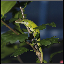

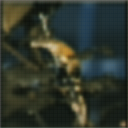

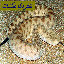

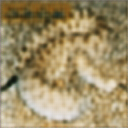

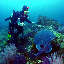

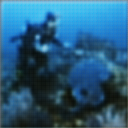

In [12]:
predictions = autoencoder.predict(X_train)
for i in range(3):
  cv2_imshow(X_train[i]*255.0)
  cv2_imshow(predictions[i]*255.0)

In [13]:
autoencoder.save('/content/gdrive/MyDrive/autoencoder/autoencoder_3.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
